Objectif : Transformer un nombre p de bandes d'un spectre en un vecteur des probabilités que le point appartienne à une des k classes -> renvoyer la classe correspondant à la probabilité la plus grande

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

from sklearn.metrics import confusion_matrix

import random

In [2]:
##Téléchargement des données

X_data=loadmat("pavia_X.mat")['pavia']
y_data=loadmat("pavia_y.mat")['pavia_gt']

X_train=X_data[201:,0:,:]
y_train=y_data[201:,0:]

X_test=X_data[:200,0:,:]
y_test=y_data[:200,0:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(895, 715, 102)
(895, 715)
(200, 715, 102)
(200, 715)


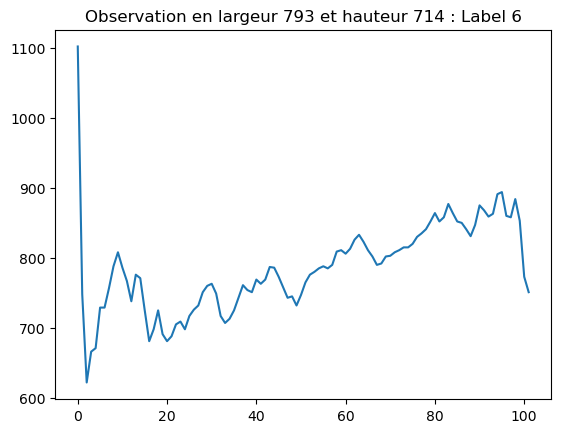

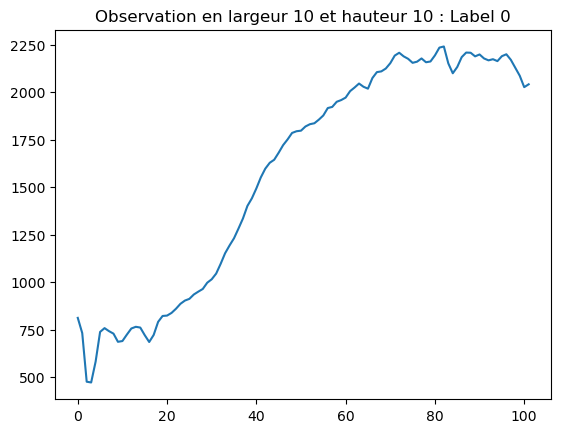

In [3]:
##Définition de la fonction d'observation

def ShowPaviaObservation(X_data,y_data,l=0,h=0): #l=largeur et h=hauteur
    plt.plot(X_data[l,h,:])
    plt.title('Observation en largeur '+str(l)+' et hauteur '+str(h)+' : Label '+str((y_data[l,h])))
    plt.show()

ShowPaviaObservation(X_train,y_train,793,714)
ShowPaviaObservation(X_train,y_train,10,10)


In [4]:
##Conversion uint16 -> int32

X_train_int32 = X_train.astype(np.int32)
X_test_int32 = X_test.astype(np.int32)

In [5]:
##Conversion en tenseur

torch_X_train = torch.from_numpy(X_train_int32).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

torch_X_test = torch.from_numpy(X_test_int32).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [6]:
##Mise à plat

torch_X_train = torch.flatten(torch_X_train, end_dim=-2)
torch_y_train = torch.flatten(torch_y_train)

torch_X_test = torch.flatten(torch_X_test, end_dim=-2)
torch_y_test = torch.flatten(torch_y_test)

In [7]:
#Création mini-batch

y_sorted = []

for i in range(0,10):
    y_sorted.append(torch.where(torch_y_train == i)[0].numpy())

In [8]:
#CNN simple : 6*51 / reshape.(-1,1,102)

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(16, 64, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(25*64, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.sig=nn.Sigmoid()
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 25*64)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sig(x) #empêche la progression de cnn -> pq ?
        
        return(x)

cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (sig): Sigmoid()
)


In [9]:
def fit(model,X_data,y_data, EPOCHS = 5, BATCH_SIZE = 32, frequencySvg=50):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.000001) #0.000001
    error = nn.CrossEntropyLoss()
    model.train()
    
    n=X_data.shape[0]
    
    List_PrctGoodPredict=[]
    
    for epoch in range(EPOCHS):
        
        Nb=0
        batchNb=0
        torch_y_pred = torch.tensor([])
        torch_y_acc = torch.tensor([])
        
        while Nb+BATCH_SIZE < n:
            
            #Tirage random
            batch = []
            for j in range(0,BATCH_SIZE//10):
                for i in range(0,10):
                    batch.append(random.choice(y_sorted[i]))
            
            #Descente de gradient stochastique
            var_X_batch = X_data[batch,:].reshape(-1,1,102).float() #reshape pour compatibilité
            var_y_batch = y_data[batch]
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()
            
            #Update
            Nb+=BATCH_SIZE
            batchNb+=1
            
            #Nombre de prédictions correctes
            predicted = torch.max(output.data, 1)[1]
            
            PrctGoodPredict = (100./BATCH_SIZE)*float((predicted == var_y_batch.view(-1)).sum())

            if batchNb%frequencySvg==0:
                print("epoch="+str(epoch)+" -- batch start="+str(Nb)+" -> Prct good predictions="+str(PrctGoodPredict))
                
            List_PrctGoodPredict.append(PrctGoodPredict)
            
    print("Moyenne du pourcentage de bonnes prédictions sur les données :")
    print(sum(List_PrctGoodPredict)/len(List_PrctGoodPredict),"%")

    return List_PrctGoodPredict

In [10]:
cnn = CNN()
List_PrctGoodPredict_CNN = fit(cnn,torch_X_train,torch_y_train,EPOCHS=5, BATCH_SIZE = 100)


epoch=0 -- batch start=5000 -> Prct good predictions=10.0
epoch=0 -- batch start=10000 -> Prct good predictions=9.0
epoch=0 -- batch start=15000 -> Prct good predictions=7.0
epoch=0 -- batch start=20000 -> Prct good predictions=10.0
epoch=0 -- batch start=25000 -> Prct good predictions=6.0
epoch=0 -- batch start=30000 -> Prct good predictions=9.0
epoch=0 -- batch start=35000 -> Prct good predictions=8.0
epoch=0 -- batch start=40000 -> Prct good predictions=11.0
epoch=0 -- batch start=45000 -> Prct good predictions=9.0
epoch=0 -- batch start=50000 -> Prct good predictions=8.0
epoch=0 -- batch start=55000 -> Prct good predictions=6.0
epoch=0 -- batch start=60000 -> Prct good predictions=6.0
epoch=0 -- batch start=65000 -> Prct good predictions=8.0
epoch=0 -- batch start=70000 -> Prct good predictions=4.0
epoch=0 -- batch start=75000 -> Prct good predictions=6.0
epoch=0 -- batch start=80000 -> Prct good predictions=9.0
epoch=0 -- batch start=85000 -> Prct good predictions=8.0
epoch=0 -- b

epoch=1 -- batch start=60000 -> Prct good predictions=50.0
epoch=1 -- batch start=65000 -> Prct good predictions=45.0
epoch=1 -- batch start=70000 -> Prct good predictions=43.0
epoch=1 -- batch start=75000 -> Prct good predictions=45.0
epoch=1 -- batch start=80000 -> Prct good predictions=44.0
epoch=1 -- batch start=85000 -> Prct good predictions=50.0
epoch=1 -- batch start=90000 -> Prct good predictions=47.0
epoch=1 -- batch start=95000 -> Prct good predictions=47.0
epoch=1 -- batch start=100000 -> Prct good predictions=45.0
epoch=1 -- batch start=105000 -> Prct good predictions=42.0
epoch=1 -- batch start=110000 -> Prct good predictions=45.0
epoch=1 -- batch start=115000 -> Prct good predictions=46.0
epoch=1 -- batch start=120000 -> Prct good predictions=48.0
epoch=1 -- batch start=125000 -> Prct good predictions=41.0
epoch=1 -- batch start=130000 -> Prct good predictions=45.0
epoch=1 -- batch start=135000 -> Prct good predictions=48.0
epoch=1 -- batch start=140000 -> Prct good predi

epoch=2 -- batch start=115000 -> Prct good predictions=44.0
epoch=2 -- batch start=120000 -> Prct good predictions=46.0
epoch=2 -- batch start=125000 -> Prct good predictions=48.0
epoch=2 -- batch start=130000 -> Prct good predictions=47.0
epoch=2 -- batch start=135000 -> Prct good predictions=45.0
epoch=2 -- batch start=140000 -> Prct good predictions=41.0
epoch=2 -- batch start=145000 -> Prct good predictions=47.0
epoch=2 -- batch start=150000 -> Prct good predictions=47.0
epoch=2 -- batch start=155000 -> Prct good predictions=48.0
epoch=2 -- batch start=160000 -> Prct good predictions=46.0
epoch=2 -- batch start=165000 -> Prct good predictions=45.0
epoch=2 -- batch start=170000 -> Prct good predictions=48.0
epoch=2 -- batch start=175000 -> Prct good predictions=43.0
epoch=2 -- batch start=180000 -> Prct good predictions=46.0
epoch=2 -- batch start=185000 -> Prct good predictions=46.0
epoch=2 -- batch start=190000 -> Prct good predictions=43.0
epoch=2 -- batch start=195000 -> Prct go

epoch=3 -- batch start=165000 -> Prct good predictions=45.0
epoch=3 -- batch start=170000 -> Prct good predictions=48.0
epoch=3 -- batch start=175000 -> Prct good predictions=45.0
epoch=3 -- batch start=180000 -> Prct good predictions=46.0
epoch=3 -- batch start=185000 -> Prct good predictions=47.0
epoch=3 -- batch start=190000 -> Prct good predictions=46.0
epoch=3 -- batch start=195000 -> Prct good predictions=41.0
epoch=3 -- batch start=200000 -> Prct good predictions=41.0
epoch=3 -- batch start=205000 -> Prct good predictions=44.0
epoch=3 -- batch start=210000 -> Prct good predictions=52.0
epoch=3 -- batch start=215000 -> Prct good predictions=46.0
epoch=3 -- batch start=220000 -> Prct good predictions=46.0
epoch=3 -- batch start=225000 -> Prct good predictions=46.0
epoch=3 -- batch start=230000 -> Prct good predictions=40.0
epoch=3 -- batch start=235000 -> Prct good predictions=48.0
epoch=3 -- batch start=240000 -> Prct good predictions=43.0
epoch=3 -- batch start=245000 -> Prct go

epoch=4 -- batch start=215000 -> Prct good predictions=46.0
epoch=4 -- batch start=220000 -> Prct good predictions=47.0
epoch=4 -- batch start=225000 -> Prct good predictions=48.0
epoch=4 -- batch start=230000 -> Prct good predictions=44.0
epoch=4 -- batch start=235000 -> Prct good predictions=49.0
epoch=4 -- batch start=240000 -> Prct good predictions=46.0
epoch=4 -- batch start=245000 -> Prct good predictions=41.0
epoch=4 -- batch start=250000 -> Prct good predictions=45.0
epoch=4 -- batch start=255000 -> Prct good predictions=47.0
epoch=4 -- batch start=260000 -> Prct good predictions=47.0
epoch=4 -- batch start=265000 -> Prct good predictions=45.0
epoch=4 -- batch start=270000 -> Prct good predictions=45.0
epoch=4 -- batch start=275000 -> Prct good predictions=44.0
epoch=4 -- batch start=280000 -> Prct good predictions=50.0
epoch=4 -- batch start=285000 -> Prct good predictions=41.0
epoch=4 -- batch start=290000 -> Prct good predictions=48.0
epoch=4 -- batch start=295000 -> Prct go

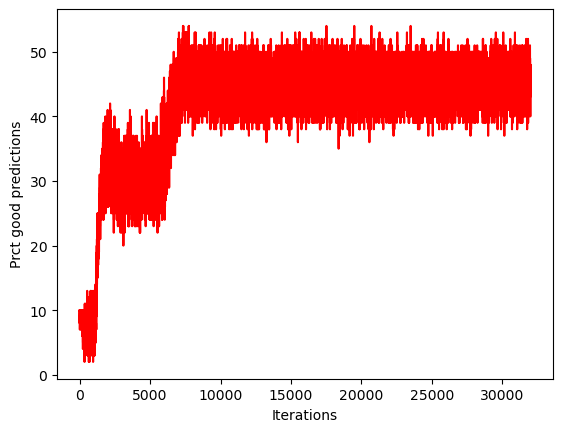

In [11]:
plt.plot(List_PrctGoodPredict_CNN,'r')
plt.xlabel('Iterations')
plt.ylabel('Prct good predictions')
plt.show()

In [16]:
##Mise en forme des données de prédictions
y_calcul_1 = cnn(torch_X_test.view(-1,1,102).float())
y_calcul_2 = cnn(torch_X_train.view(-1,1,102).float())

y_pred = torch.tensor([])

for i in range(y_calcul_1.shape[0]):
       y_pred = torch.cat([y_pred, torch.argmax(y_calcul_1[i]).reshape(1)])

for i in range(y_calcul_2.shape[0]):
       y_pred = torch.cat([y_pred, torch.argmax(y_calcul_2[i]).reshape(1)])

In [18]:
#Matrice de confusion
print(confusion_matrix(torch.cat([torch_y_test, torch_y_train]), y_pred))

[[443491  19397      1      0  63210   3128      0  45885   8702  51189]
 [     0  65238      0      0    558      0      0      2      0      0]
 [  7592      0      0      0      0      0      0      0      0      5]
 [  3090      0      0      0      0      0      0      0      0      0]
 [   264      0      0      0   2209      1      0    211      0      0]
 [  4513      0      0      0   1311    742      0     15      0      0]
 [  4163      0      0      0   1428      8      0   3647      2      0]
 [   284      0      0      0    276      2      0   6724      0      1]
 [ 42271      0      0      0     70      0      0     18    414      0]
 [    26      1      0      0      0      0      0      1      0   2835]]


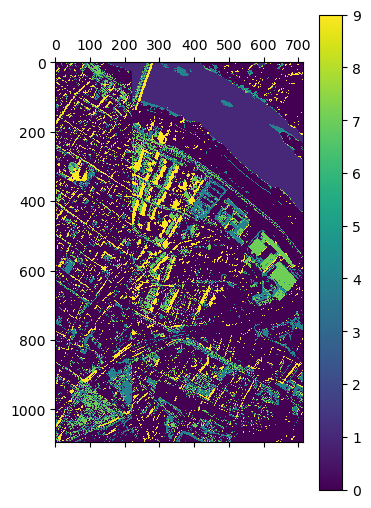

In [19]:
##Observation des prédictions
def ShowPaviaPrediction(y_data):
    plt.matshow(y_data)
    plt.colorbar()
    plt.show()

y_pred = y_pred.detach().numpy().reshape(1095,715)    
ShowPaviaPrediction(y_pred)